# **Evidence-Based Static Predcition**


---


 a new technique for program-based branch
prediction
based on a general approach, called
Evidence-Based Static Prediction (ESP)

In [ ]:
import numpy as np
import pandas as pd
import os
import torch
import torch.nn as nn
import torch.optim as optim
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import precision_score, recall_score, f1_score

Instead of training on one branch history file, the models are trained on multiple programs introducing diversity -- referred to as a corpus.

In [ ]:
def load_branch_datasets(folder_path):
  all_data = []

  for filename in os.listdir(folder_path):
    if filename.endswith('.csv'):
      df = pd.read_csv(os.path.join(folder_path, filename), encoding='utf-8')
      df.columns = df.columns.str.strip().str.lower()
      if 'branch history' in df.columns and "branch outcome" in df.columns:
        all_data.append(df)

  return pd.concat(all_data, ignore_index=True) if all_data else None

Prepare the dataset properly and split the dataset into training and testing.

In [ ]:
"""dataset_folder = ''
df = load_branch_datasets(dataset_folder)
if df is None:
  exit()"""

from google.colab import files
uploaded = files.upload()
df = pd.read_csv("BranchPredictorDataset.csv", encoding='utf-8')
df.columns = df.columns.str.strip().str.lower()

expected_history_col = "branch history"
expected_outcome_col = "branch outcome"
program_counter_col = "program counter"

df[expected_history_col] = df[expected_history_col].astype(str).apply(lambda x: [int(b) for b in x if b.isdigit()])
df['branch history length'] = df[expected_history_col].apply(len)
X = np.array(df[expected_history_col].tolist())
y = df[expected_outcome_col].values
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

Saving BranchPredictorDataset.csv to BranchPredictorDataset.csv


Function containing the metrics for evaluating both models.

In [ ]:
def evaluate_model(model, X_train, X_test, y_train, y_test):
    y_train_pred = model.predict(X_train)
    y_test_pred = model.predict(X_test)

    train_f1 = f1_score(y_train, y_train_pred, average='weighted', zero_division=0)
    test_f1 = f1_score(y_test, y_test_pred, average='weighted', zero_division=0)

    print(f"\nModel: {model.__class__.__name__}")
    print(f"Train F1 Score: {train_f1:.4f} | Test F1 Score: {test_f1:.4f}")

    cv_scores = cross_val_score(model, X, y, cv=5, scoring="f1_weighted")
    print(f"Cross-validation F1 scores: {cv_scores}")
    print(f"Mean CV F1-score: {np.mean(cv_scores):.4f}")

In [ ]:
decision_tree = DecisionTreeClassifier(max_depth=5, ccp_alpha=0.01)
decision_tree.fit(X_train, y_train)
evaluate_model(decision_tree, X_train, X_test, y_train, y_test)


Model: DecisionTreeClassifier
Train F1 Score: 0.9826 | Test F1 Score: 0.9762
Cross-validation F1 scores: [0.91605183 0.99088105 0.98905024 0.98538121 0.89935166]
Mean CV F1-score: 0.9561


Our goal is to have a system that can effectively predict that a branch will
be taken based on its static feature set. This system should accurately
predict not just for the programs in the corpus, but also for previously
unseen programs.
Initialising Nueral Networks.

In [ ]:
class BranchPredictorNN(nn.Module):
    def __init__(self, input_size):
        super(BranchPredictorNN, self).__init__()
        self.fc1 = nn.Linear(input_size, 64)
        self.fc2 = nn.Linear(64, 32)
        self.fc3 = nn.Linear(32, 1)
        self.activation = nn.ReLU()
        self.output_activation = nn.Sigmoid()

    def forward(self, x):
        x = self.activation(self.fc1(x))
        x = self.activation(self.fc2(x))
        x = self.output_activation(self.fc3(x))
        return x

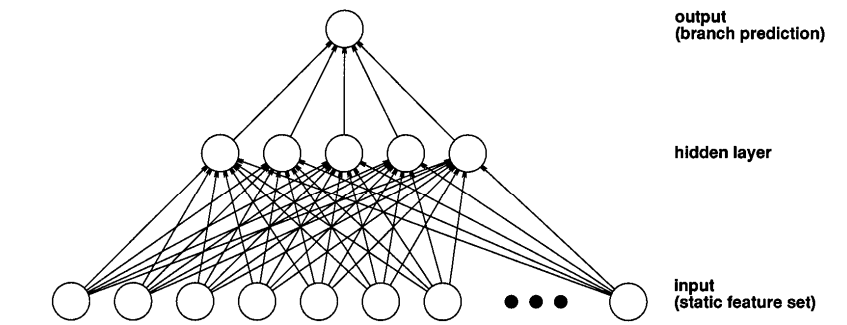

In [ ]:
X_train_tensor = torch.tensor(X_train, dtype=torch.float32)
X_test_tensor = torch.tensor(X_test, dtype=torch.float32)
y_train_tensor = torch.tensor(y_train, dtype=torch.float32).view(-1, 1)
y_test_tensor = torch.tensor(y_test, dtype=torch.float32).view(-1, 1)

In [ ]:
input_size = X_train.shape[1]
nn_model = BranchPredictorNN(input_size)
criterion = nn.BCELoss()
optimizer = optim.Adam(nn_model.parameters(), lr=0.001)

epochs = 50
for epoch in range(epochs):
    optimizer.zero_grad()
    outputs = nn_model(X_train_tensor)
    loss = criterion(outputs, y_train_tensor)
    loss.backward()
    optimizer.step()
    if epoch % 10 == 0:
        print(f"Epoch [{epoch}/{epochs}], Loss: {loss.item():.4f}")

Epoch [0/50], Loss: 0.6828
Epoch [10/50], Loss: 0.6087
Epoch [20/50], Loss: 0.5247
Epoch [30/50], Loss: 0.4309
Epoch [40/50], Loss: 0.3363


In [ ]:
def evaluate_model2(model, X_train, X_test, y_train, y_test):

    with torch.no_grad():
        y_train_pred = model(X_train).detach().numpy().round()
        y_test_pred = model(X_test).detach().numpy().round()

    train_f1 = f1_score(y_train.detach().numpy(), y_train_pred, average='weighted', zero_division=0)
    test_f1 = f1_score(y_test.detach().numpy(), y_test_pred, average='weighted', zero_division=0)

    print(f"\nModel: {model.__class__.__name__}")
    print(f"Train F1 Score: {train_f1:.4f} | Test F1 Score: {test_f1:.4f}")


In [ ]:
y_pred_nn = nn_model(X_test_tensor).detach().numpy().round()
print("\nNeural Network Model Evaluation:")
evaluate_model2(nn_model, X_train_tensor, X_test_tensor, y_train_tensor, y_test_tensor)

y_pred_full = decision_tree.predict(X)
output_full_df = pd.DataFrame({
    "Program Counter": df[program_counter_col] if program_counter_col else "N/A",
    "Branch History": df[expected_history_col].apply(lambda x: ''.join(map(str, x))),
    "Actual Outcome": y,
    "Predicted Outcome": y_pred_full
})


Neural Network Model Evaluation:

Model: BranchPredictorNN
Train F1 Score: 0.9454 | Test F1 Score: 0.9485
